# Analysis of Historical NYC Development Data 2000-2018

### Import required libraries

In [53]:
# Import all required libraries for analysis
import os
import numpy as np
import pandas as pd
import requests

# Import Socrata from sodapy to use API
from sodapy import Socrata

In [298]:
# Import libraries required for visualization
%matplotlib inline
import hvplot.pandas
import plotly.express as px
from panel.interact import interact

## Retrieve API Data

### Define information for required dataset

In [55]:
# dataset identifying information from NYC OPEN DATA
socrata_domain = 'data.cityofnewyork.us'
socrata_dataset_identifier = 'ic3t-wcy2'

# get API token from environment
socrata_token = os.getenv('genS_token')



In [54]:
# create client and pass in the token
client = Socrata(socrata_domain, socrata_token)

### Extract relevant data using the 'query' method

In [188]:
# write query to get borough, block, lot, filing date, cost estimate and lines of data
# limit field obtained from the dataset information, had to be hardcoded
query = """select Borough, Block, Lot, Pre__Filing_Date, Initial_Cost limit 1700421"""

# get data by passing in dataset identifier and the query
results = client.get(socrata_dataset_identifier, query=query)

# pass results into a dataframe
df = pd.DataFrame(results)

# check to see the stats on the dataframe
# check to see that all rows were retrieved
df.describe()

,Borough,Block,Lot,Pre__Filing_Date,Initial_Cost
count,1700421,1699669,1699665,1700421,1700421
unique,5,13794,1942,5889,90397
top,MANHATTAN,00016,00001,06/28/2019,$0.00
freq,753812,6642,209140,1717,460327


In [212]:
# place 'results' into a dataframe called 'dob_filing' for manipulation
# copy made just incase, so another get request doesn't have to be made
dob_filing = pd.DataFrame(results)

### Clean up development data

In [213]:
# converting the 'Initial_Cost' field from an 'object' into a 'float'
# drop '$' and then convert using .astype function
dob_filing['Initial_Cost'] = dob_filing['Initial_Cost'].str.replace('$','')
dob_filing['Initial_Cost'] = dob_filing['Initial_Cost'].astype('float')

# check a few lines
dob_filing.head()

,Borough,Block,Lot,Pre__Filing_Date,Initial_Cost
0,BROOKLYN,01224,00020,02/01/2008,10000.0
1,MANHATTAN,00498,00011,03/29/2016,1487158.0
2,BROOKLYN,01153,00023,05/09/2007,30000.0
3,MANHATTAN,01308,07501,04/05/2016,55000.0
4,BROOKLYN,00321,00009,05/15/2006,290000.0


In [214]:
# extract year and create 'Year' column from the last 4 elements of Pre__Filing_Date
dob_filing['Year'] = dob_filing.Pre__Filing_Date.str[-4:]

# extract block from the last four elements from the 'Block' string, also rename 'BLOCK'
dob_filing['BLOCK'] = dob_filing.Block.str[-4:]

# check a few lines
dob_filing.head()

,Borough,Block,Lot,Pre__Filing_Date,Initial_Cost,Year,BLOCK
0,BROOKLYN,01224,00020,02/01/2008,10000.0,2008,1224
1,MANHATTAN,00498,00011,03/29/2016,1487158.0,2016,0498
2,BROOKLYN,01153,00023,05/09/2007,30000.0,2007,1153
3,MANHATTAN,01308,07501,04/05/2016,55000.0,2016,1308
4,BROOKLYN,00321,00009,05/15/2006,290000.0,2006,0321


In [215]:
# drop irrelevant columns
dob_filing.drop(columns=['Block','Lot','Pre__Filing_Date'], inplace=True)

## Development by Neighborhood

### Prepare dataframe for a JOIN to add neighborhoods

In [468]:
# convert 'BLOCK' datatype to float, drop nulls, then convert to integer
dob_filing['BLOCK'] = dob_filing['BLOCK'].astype('float')
dob_filing.dropna(inplace=True)
dob_filing['BLOCK'] = dob_filing['BLOCK'].astype('int')

# change Borough to BOROUGH and strip all whitespace
dob_filing.rename(columns={'Borough':'BOROUGH'}, inplace=True)
dob_filing['BOROUGH']=dob_filing['BOROUGH'].str.strip()

# check a few rows
dob_filing.head()

,BOROUGH,Initial_Cost,Year,BLOCK
0,BROOKLYN,10000.0,2008,1224
1,MANHATTAN,1487158.0,2016,498
2,BROOKLYN,30000.0,2007,1153
3,MANHATTAN,55000.0,2016,1308
4,BROOKLYN,290000.0,2006,321


In [469]:
# check datatypes to ensure compatibility
dob_filing.dtypes

BOROUGH          object
Initial_Cost    float64
Year             object
BLOCK             int32
dtype: object

### Import junction table with Neighborhood, Block, Borough and Zipcode

In [540]:
# import junction table 
mttn_sales_path = 'JUNCTION_TABLE/neigh_block_zip_borough.csv'
mttn_nbz_df = pd.read_csv(mttn_sales_path)

# check stats and sample of imported dataframe
print(mttn_nbz_df.describe())
mttn_nbz_df.sample(50)

              BLOCK       ZIPCODE
count  48405.000000  48405.000000
mean    5556.249458  11101.982894
std     3959.804642    459.354086
min        1.000000  10001.000000
25%     2262.000000  11201.000000
50%     4835.000000  11233.000000
75%     8102.000000  11378.000000
max    16350.000000  33803.000000


,NEIGHBORHOOD,BLOCK,ZIPCODE,BOROUGH
35886,EAST NEW YORK,4169,11208,BROOKLYN
40145,WILLIAMSBURG-EAST,2977,11237,BROOKLYN
30072,SOUTH OZONE PARK,11607,11420,QUEENS
41139,WYCKOFF HEIGHTS,3302,11226,BROOKLYN
11097,BELLEROSE,8646,11426,QUEENS
1555,RIVERDALE,5743,10463,BRONX
33743,BENSONHURST,6193,11204,BROOKLYN
35500,CROWN HEIGHTS,1163,11238,BROOKLYN
32659,RIDGEWOOD,3541,11385,QUEENS
18972,ST. ALBANS,10295,11433,QUEENS


### Prepare Dataframe for a JOIN

In [541]:
# drop zipcode column
mttn_nbz_df.drop(columns=['ZIPCODE'], inplace=True)

# strip whitespace from 'NEIGHBORHOOD' column
mttn_nbz_df['NEIGHBORHOOD'] = mttn_nbz_df['NEIGHBORHOOD'].str.strip()

# drop all duplicates
mttn_nbz_df.drop_duplicates(inplace=True)

# check all datatypes and column names to ensure compatibility
mttn_nbz_df.dtypes

NEIGHBORHOOD    object
BLOCK            int64
BOROUGH         object
dtype: object

### Filter for sizable development projects

In [536]:
# slice dataframe to only include projects where the estimated cost is over $40,000
# add condition for block to make sure 'BLOCK' remains an integer
development_df = dob_filing[
    (dob_filing['Initial_Cost']>=40000) &
    (dob_filing['BLOCK']>10)
]

# set both 'BLOCK' and 'BOROUGH' as indices
development_df.set_index(['BLOCK','BOROUGH'], inplace=True)

# check stats for resulting dataset and check a few rows
print(development_df.describe())
development_df.head()

       Initial_Cost
count  5.145210e+05
mean   3.438878e+05
std    3.235423e+06
min    4.000000e+04
25%    6.000000e+04
50%    1.010000e+05
75%    2.350000e+05
max    9.663318e+08


,,Initial_Cost,Year
BLOCK,BOROUGH,,
498,MANHATTAN,1487158.0,2016
1308,MANHATTAN,55000.0,2016
321,BROOKLYN,290000.0,2006
4738,BROOKLYN,358000.0,2016
5689,BROOKLYN,680339.0,2016


### Add Neighborhood column to development data

In [543]:
# use a left merge on the development dataframe to ensure each development entry gets a neighborhood
# merge on both BLOCK and BOROUGH
boroughs_neigh = pd.merge(new_development_df,mttn_nbz_df, on=['BLOCK','BOROUGH'], how='left')

# drop any duplicates and nulls
boroughs_neigh.drop_duplicates(inplace=True)
boroughs_neigh.dropna(inplace=True)

# check stats for resulting dataframe
print(boroughs_neigh.describe())

# check join for a random borough by slicing
boroughs_neigh[boroughs_neigh['BOROUGH']=='QUEENS']


       Initial_Cost          BLOCK
count  3.828180e+05  382818.000000
mean   3.780362e+05    2101.632013
std    3.291957e+06    2119.972226
min    5.000000e+04      11.000000
25%    7.500000e+04     825.000000
50%    1.250000e+05    1294.000000
75%    2.700000e+05    2427.000000
max    9.663318e+08    9999.000000


,Initial_Cost,Year,BLOCK,BOROUGH,NEIGHBORHOOD
23,125000.0,2000,2495,QUEENS,ELMHURST
25,500000.0,2000,6540,QUEENS,FLUSHING-SOUTH
34,100000.0,2000,9612,QUEENS,RICHMOND HILL
35,75000.0,2000,9612,QUEENS,RICHMOND HILL
38,60000.0,2000,9417,QUEENS,RICHMOND HILL
40,2173268.0,2014,1349,QUEENS,ELMHURST
47,360000.0,2000,8489,QUEENS,GLEN OAKS
54,168500.0,2015,2956,QUEENS,MIDDLE VILLAGE
56,170000.0,2015,1281,QUEENS,JACKSON HEIGHTS
68,275000.0,2017,7256,QUEENS,JAMAICA ESTATES


### Export Development Data by Neighborhood for Dashboard

In [570]:
# use 'to_csv' function to export to csv
boroughs_neigh.to_csv('dash_dev.csv')

# A BIG Picture of Development in NYC (2000-2018)

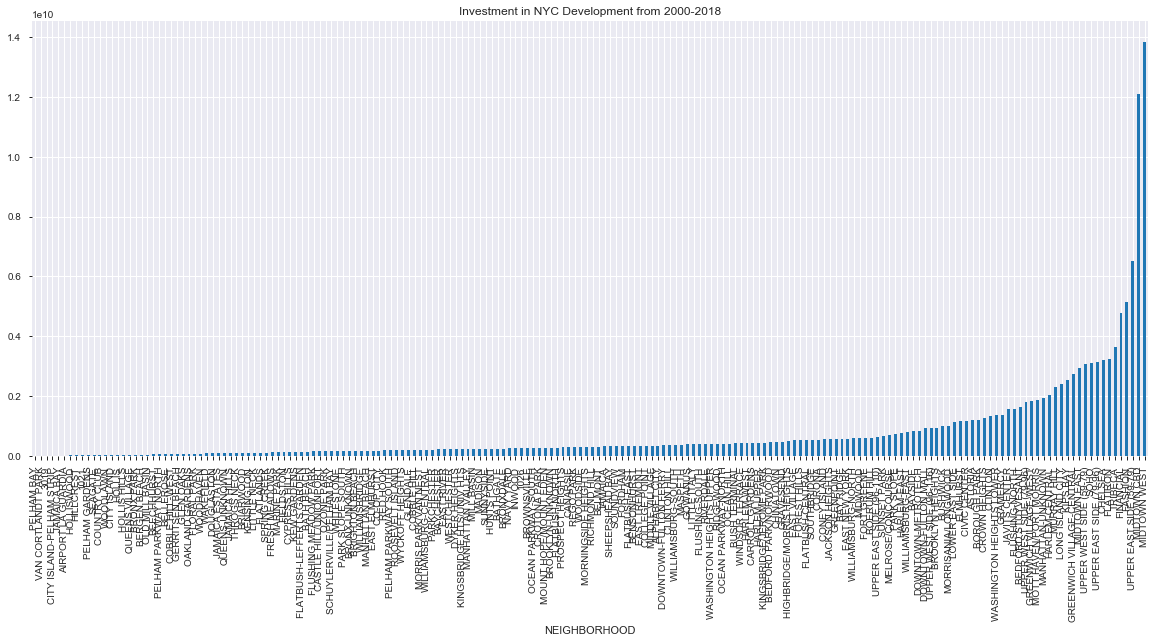

In [544]:
# Define a dataframe to see total estimated development costs across Neighborhoods
dev_yearly = boroughs_neigh.groupby(['NEIGHBORHOOD'])['Initial_Cost'].sum().sort_values()

# plot all Neighborhoods in order to check that the data makes sense
total_investment = dev_yearly.plot.bar(figsize=[20,8],rot=90, title = 'Investment in NYC Development from 2000-2018')

# Development in NYC through the years

### Define new dataframe to show cost per year per neighborhood

In [551]:
# Define new dataframe that sums all the yearly development costs per neighborhood
boroughs_yearly_dev = boroughs_neigh.groupby(['NEIGHBORHOOD','Year']).sum().reset_index()

# drop irrelevant columns
boroughs_yearly_dev.drop(columns=['BLOCK'], inplace=True)

# check a few rows of the dataframe
boroughs_yearly_dev.tail(20)


# create a list of all unique neighborhoods
# slice for Neighborhoods
all_neighborhoods = boroughs_yearly_dev['NEIGHBORHOOD']

# drop nulls
all_neighborhoods.dropna(inplace=True)

# use 'set' to get unique neighborhoods, and use 'list' conver to list format
all_neighborhoods = list(set(all_neighborhoods))

,NEIGHBORHOOD,Year,Initial_Cost
3660,WYCKOFF HEIGHTS,2000,5745414.0
3661,WYCKOFF HEIGHTS,2001,1101000.0
3662,WYCKOFF HEIGHTS,2002,983000.0
3663,WYCKOFF HEIGHTS,2003,3472030.0
3664,WYCKOFF HEIGHTS,2004,3291895.0
3665,WYCKOFF HEIGHTS,2005,3268300.0
3666,WYCKOFF HEIGHTS,2006,2532368.0
3667,WYCKOFF HEIGHTS,2007,5810766.0
3668,WYCKOFF HEIGHTS,2008,3949087.0
3669,WYCKOFF HEIGHTS,2009,5214540.0


### Visualize Development through the years

In [549]:
# define function to slice dataframe and return plot of an individual neighborhood's developemnt spending over time
def neigh_slice(Neighborhood):
    
    # slice dataframe by neighborhood
    neigh_slice = boroughs_yearly_dev[boroughs_yearly_dev['NEIGHBORHOOD'].isin([Neighborhood])]
    
    # return hvplot of development price vs year
    return neigh_slice.hvplot.line(
        x='Year',
        y='Initial_Cost',
        title='NYC Real Estate Est. Development Spending'
        ).opts(xlabel='Year', ylabel='Estimated Development Spending',yformatter="%.0f")

# use interact to make an interactive plot where the plot responds to neighborhood dropdown
interact(neigh_slice, Neighborhood=all_neighborhoods)

Column
    [0] Column
        [0] Select(name='Neighborhood', options=['FLORAL PARK', ...], value='FLORAL PARK')
    [1] Row
        [0] HoloViews(Curve, name='interactive12600')

### Visualize Cumulative Development through the Years

In [552]:
# define a function to look at cumulative development over time of a neighborhood
def cumulative_plot(Neighborhood):
    
    # slice dataframe by neighborhood
    neigh_slice = boroughs_yearly_dev[boroughs_yearly_dev['NEIGHBORHOOD'].isin([Neighborhood])]
    
    # set index as year
    neigh_slice.set_index('Year', inplace=True)
    
    # calculative cumulative sums of development costs
    cum_fcn = neigh_slice['Initial_Cost'].cumsum()
    
    # return hvplot of cumulative development costs vs year
    return cum_fcn.hvplot.line()

# use interact to make an interactive plot where the plot responds to neighborhood dropdown
interact(cumulative_plot, Neighborhood=all_neighborhoods)

Column
    [0] Column
        [0] Select(name='Neighborhood', options=['FLORAL PARK', ...], value='FLORAL PARK')
    [1] Row
        [0] HoloViews(Curve, name='interactive12752')

# Metrics for Development

### Define function to calculate metrics

In [561]:
# define function to calculate metrics based on neighborhoods
def cumulative_dev_stats(Neighborhood):
    
    # slice dataframe by neighborhood
    neigh_slice = boroughs_yearly_dev[boroughs_yearly_dev['NEIGHBORHOOD'].isin([Neighborhood])]
    neigh_slice.set_index('Year', inplace=True)
    
    # calculate cumulative sums
    cum_fcn = neigh_slice['Initial_Cost'].cumsum()
    
    # calculate rate of change for the cumulative sums
    returns = cum_fcn.pct_change()
    
    # extract present cumulative sum, the last entry 
    present_sum = cum_fcn[-1:][0]
    
    # calculate avg rate of change and other metrics, excluding 2019 due to incomplete data
    avg_pct_change = round(returns[:-1].mean(),4)
    pct_change_3yr = round(returns[-4:-1].mean(),4)
    comparison_3yr = round(pct_change_3yr - avg_pct_change,4)
    pct_change_5yr = round(returns[-6:-1].mean(),4)
    comparison_5yr = round(pct_change_5yr - avg_pct_change,4)
    
    # return list of metrics
    return [present_sum, avg_pct_change, pct_change_3yr, comparison_3yr, pct_change_5yr, comparison_5yr]

### Generate a dictionary that contains Metrics by Neighborhood

In [554]:
# initialize a dictionary, to be converted to dataframe, 
development_stats={}

# use a for loop to iterate over list of neighborhoods, defined above
for Neighborhood in all_neighborhoods:
    
    # call cumulative_dev_stats function and write results into dictionary
    development_stats[Neighborhood]=cumulative_dev_stats(Neighborhood)

### Convert the dictionary into a dataframe

In [568]:
# convert dictionary to dataframe
stats_df = pd.DataFrame(development_stats)

# define new column names
new_columns = ['cumulative_sum','avg_pct_change','pct_change_3yr','comparison_3yr','pct_change_5yr','comparison_5yr']

# transpose the dataframe to neighborhood is in rows
dev_df = stats_df.transpose()

# add new column names
dev_df.columns=new_columns

# drop nulls
dev_df.dropna(inplace=True)

# sort values by the cumulative sum per neighborhood
dev_df.sort_values(['cumulative_sum'], ascending=False, inplace=True)

# check the top 50 rows of the dataframe to make sure it makes sense
dev_df.head(50)

,cumulative_sum,avg_pct_change,pct_change_3yr,comparison_3yr,pct_change_5yr,comparison_5yr
MIDTOWN WEST,1.384959e+10,0.2515,0.1094,-0.1421,0.125,-0.1265
MIDTOWN CBD,1.209472e+10,139.3866,0.1198,-139.2668,0.119,-139.2676
UPPER EAST SIDE (59-79),6.525430e+09,147.6482,0.0966,-147.5516,0.104,-147.5442
FASHION,5.149296e+09,0.2746,0.1110,-0.1636,0.120,-0.1546
FINANCIAL,4.768688e+09,0.1909,0.0985,-0.0924,0.141,-0.0499
TRIBECA,3.627881e+09,0.2498,0.1132,-0.1366,0.162,-0.0878
FLATIRON,3.242116e+09,0.2764,0.0981,-0.1783,0.134,-0.1424
CHELSEA,3.202925e+09,0.1939,0.0938,-0.1001,0.140,-0.0539
UPPER EAST SIDE (79-96),3.131422e+09,0.2642,0.0933,-0.1709,0.107,-0.1572
SOHO,3.098083e+09,0.2502,0.1742,-0.0760,0.163,-0.0872


### Export dataframe as csv to feed into Joint_Analysis.ipynb

In [560]:
# use 'to_csv' function to export as csv
dev_df.to_csv('dev_df.csv')